# lets get some RF + PCAs going

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
CARIACO = pd.read_csv("../DATA/January/Combined_CARIACO_data_v5.csv")
CARIACO['date'] = pd.to_datetime(CARIACO['time_month'])
CARIACO = CARIACO.set_index('date')

In [4]:
CARIACO.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1995-11-01 to 2021-11-01
Data columns (total 96 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    316 non-null    int64  
 1   cdww                          299 non-null    float64
 2   iews                          299 non-null    float64
 3   inss                          299 non-null    float64
 4   mcc                           299 non-null    float64
 5   mwp                           299 non-null    float64
 6   si10                          299 non-null    float64
 7   sp                            300 non-null    float64
 8   sst                           299 non-null    float64
 9   t2m                           299 non-null    float64
 10  tauoc                         299 non-null    float64
 11  u10                           299 non-null    float64
 12  ust                           300 non-null   

## Create Subframes without NAs

In [5]:
CSUB1 = CARIACO[['u10',
         'sst',
         'mtpr',
         'cdir',
         'e',
         'Satellite_chla',
        ]].dropna()

CSUB1.columns

Index(['u10', 'sst', 'mtpr', 'cdir', 'e', 'Satellite_chla'], dtype='object')

# scatter plot function

In [13]:
def plot_scatter_matrix(data, colnamelist):
    """plot scatter matrix of data"""
    
    ax0 = pd.plotting.scatter_matrix(data, diagonal='kde', figsize=(10, 10))
        
    xlen = len(ax0[0,:])
    ylen = len(ax0[:,0])
    
    for ax, i in zip(ax0[:,0], range(ylen)):
        ax.set_ylabel(colnamelist[i], fontsize=14, weight='bold')
        
    for ax, i in zip(ax0[ylen-1,:], range(xlen)):
        ax.set_xlabel(colnamelist[i], fontsize=14, weight='bold')
        
    for ax in ax0.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')

    plt.tight_layout()
    plt.show()

    # plt.savefig('Plots/PRESENTATION_ScatterMatrix.png')

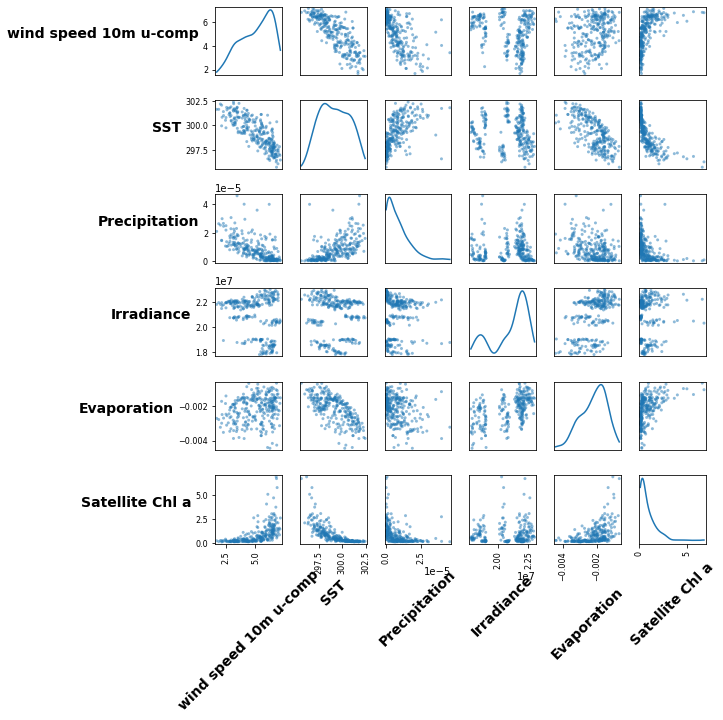

In [14]:
colnamelist = ['wind speed 10m u-comp', 'SST', 'Precipitation', 'Irradiance',
                   'Evaporation', 'Satellite Chl a']

plot_scatter_matrix(CSUB1, colnamelist)

# PCA

In [9]:


#pca_pytho.explained_variance_ratio_[0:2] * 100

In [46]:
# ------------------------------
# Principal Component Analysis 
# ------------------------------
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from matplotlib.gridspec import GridSpec

def pca_analysis(dataP, colnamelist):
    """ PCA function """
    colnum = len(colnamelist)
    scaler = StandardScaler()
    scaler.fit(dataP)
    scaled_dataP = scaler.transform(dataP)

    pca_pytho = PCA(n_components=colnum, whiten=True)
    pcaresult = pca_pytho.fit_transform(scaled_dataP)
    expl_var = pca_pytho.explained_variance_ratio_[0:2] * 100
    print(expl_var)
    pcacoef = pd.DataFrame(columns=['PC1', 'PC2', 'VarName', 'VarColor'])
    pcacoef.PC1 = np.transpose(pca_pytho.components_)[:, 0]
    pcacoef.PC2 = np.transpose(pca_pytho.components_)[:, 1]
    pcacoef.VarName = colnamelist
    pcacoef.VarColor = ['grey', 'grey', 'grey', 'grey', 'grey', 'black']
    scalex = 1. / (pcaresult[:, 0].max() - pcaresult[:, 0].min())
    scaley = 1. / (pcaresult[:, 1].max() - pcaresult[:, 1].min())

    # need more values here
    offsetx = [1.15, 1.15, 1.25, 1.25, 1.25, 1.45]
    offsety = [1.25, 1.25, 1.25, 1.25, 1.25, 1.30]

    fig1 = plt.figure()
    gs = GridSpec(4, 4)
    ax1 = plt.subplot(gs[:, 1:3])
    ax2 = plt.subplot(gs[0:2, 3:4])
    ax3 = plt.subplot(gs[2:4, 3:4])

    ax1.scatter(pcaresult[:, 0], pcaresult[:, 1])
    for i in range(pcacoef.shape[0]):
        ax1.arrow(0, 0, pcacoef.PC1[i] / scalex, pcacoef.PC2[i] / scaley, color=pcacoef.VarColor[i], linewidth=2, alpha=0.6,
                  head_width=0.15, head_length=0.15)
        ax1.text(pcacoef.PC1[i] * offsetx[i] / scalex, pcacoef.PC2[i] * offsety[i] / scaley, pcacoef.VarName[i],
                 color=pcacoef.VarColor[i], ha='center', va='center')
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-5, 4)
    ax1.set_xlabel(r'PC1 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[0]), fontsize=14, weight='bold')
    ax1.set_ylabel(r'PC2 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[1]), fontsize=14, weight='bold')

    ax2.barh(range(colnum), pcacoef.sort_values(by=['PC1']).PC1 * 1.15 / scalex, color=pcacoef.sort_values(by=['PC1']).VarColor)
    ax2.set_xlim(-4, 4)
    ax2.set_xticklabels([])
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(colnum))
    ax2.set_yticklabels(pcacoef.sort_values(by=['PC1']).VarName)
    ax2.text(-3.5, 6, 'PC1', fontsize=12, weight='bold')

    ax3.barh(range(colnum), pcacoef.sort_values(by=['PC2']).PC2 * 1.15 / scaley, color=pcacoef.sort_values(by=['PC2']).VarColor)
    ax3.set_xlim(-4, 4)
    ax3.yaxis.tick_right()
    ax3.set_yticks(np.arange(colnum))
    ax3.set_yticklabels(pcacoef.sort_values(by=['PC2']).VarName)
    ax3.set_xlabel('Loadings', fontsize=14, weight='bold')
    ax3.text(-3.5, 6, 'PC2', fontsize=12, weight='bold')

    fig1.set_figheight(6)
    fig1.set_figwidth(12)
    plt.tight_layout()
    #plt.show()
    #fig1.savefig('Plots/PRESENTATION_PCA_tests.png')

[53.8064182  25.05364389]


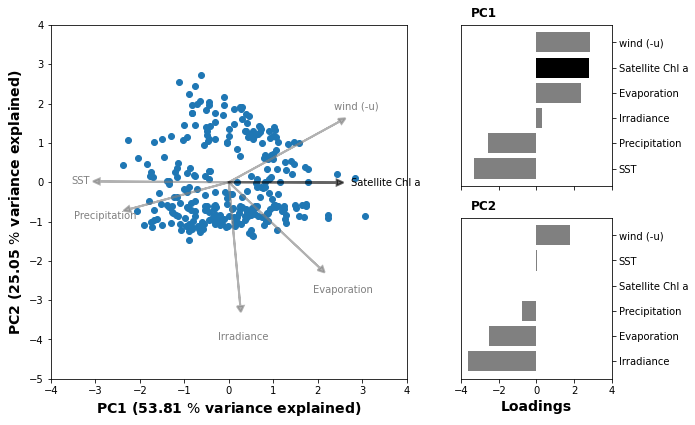

In [47]:
pca_analysis(CSUB1, colnamelist)

# RANDOM FOREST

In [53]:
dataP = CSUB1

/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF Chlorophyll: oob-error=0.42, r^2=0.65, % variance explained=65.92
                 VarName  Satellite_chla
0  wind speed 10m u-comp        7.969738
1                    SST       72.437449
2          Precipitation        2.669950
3             Irradiance        5.037676
4            Evaporation       11.885187
2     2.669950
3     5.037676
0     7.969738
4    11.885187
1    72.437449
Name: Satellite_chla, dtype: float64
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)


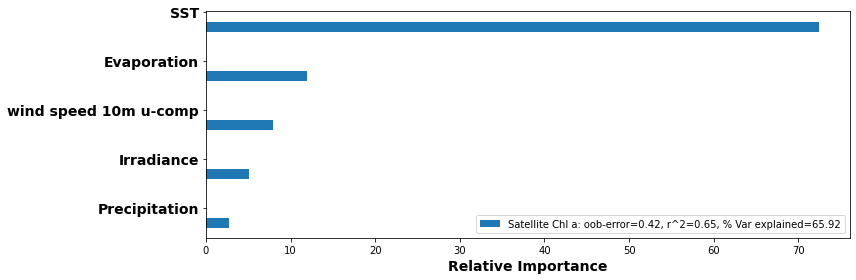

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

testsize = 0.25
vars2take = [0, 1, 2, 3, 4]
#Chlorophyll
X_trainBiom, X_testBiom, y_trainBiom, y_testBiom = train_test_split(dataP.take(vars2take, axis=1), 
                                                                    dataP.Satellite_chla,
                                                                    test_size=testsize)
RFregBiomass = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass.fit(X_trainBiom, y_trainBiom)
predicted_testBiom = RFregBiomass.predict(X_testBiom)




print('RF Chlorophyll: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
    explained_variance_score(y_testBiom, predicted_testBiom) * 100))



# change attributes below!
RFVarImp = pd.DataFrame(columns=['VarName', 'Satellite_chla'])
RFVarImp.VarName = colnamelist[:5]
RFVarImp.Satellite_chla = RFregBiomass.feature_importances_ * 100

print(RFVarImp)
print(RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla)
print(RFregBiomass)


fig2 = plt.figure()
varRFnum = 5
plt.barh(np.arange(varRFnum) - 0.3, RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla, height=.2,
         label='Satellite Chl a: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
             explained_variance_score(y_testBiom, predicted_testBiom) * 100))



plt.yticks(np.arange(varRFnum), RFVarImp.sort_values(by=['Satellite_chla']).VarName, fontsize=14, weight='bold')
plt.xlabel('Relative Importance', fontsize=14, weight='bold')
plt.legend()#fontsize='x-small')
fig2.set_figheight(4)
fig2.set_figwidth(12)
plt.tight_layout()
plt.show()
#fig2.savefig('PRESENTATION_TEST_RandomFOrest.png')

In [ ]:
## GROUP 1

- ERA5 Wind
- ERA5 SST
- ERA5 Precipitation
- ERA5 Evaporation
- ERA5 irradiance
- MERGED Satellite Chl a

In [ ]:
## GROUP 2

- Satellite merged
- ERA5 mtpr (precipitation)
- TimeSeries 21° Isotherm
- TimeSeries Chlorophyll 35m
- TimeSeries Tchla


In [ ]:
## GROUP 3

- ERA5 cdir irradiance
- TimeSeries Temperature 35m
- TimeSeries 21° Isotherm
- TimeSeries NO3  35m
- TimeSeries PO4  35m
- TimeSeries SiO4  35m

- HPLC Func groups (8x)

# GROUP 1 plots

In [19]:
CSUB1 = CARIACO[['u10',
         'sst',
         'mtpr',
         'cdir',
         'e',
         'Satellite_chla',
        ]].dropna()

CSUB1.columns

colnamelist = ['wind (-u)', 'SST', 'Precipitation', 'Irradiance',
                   'Evaporation', 'Satellite Chl a']

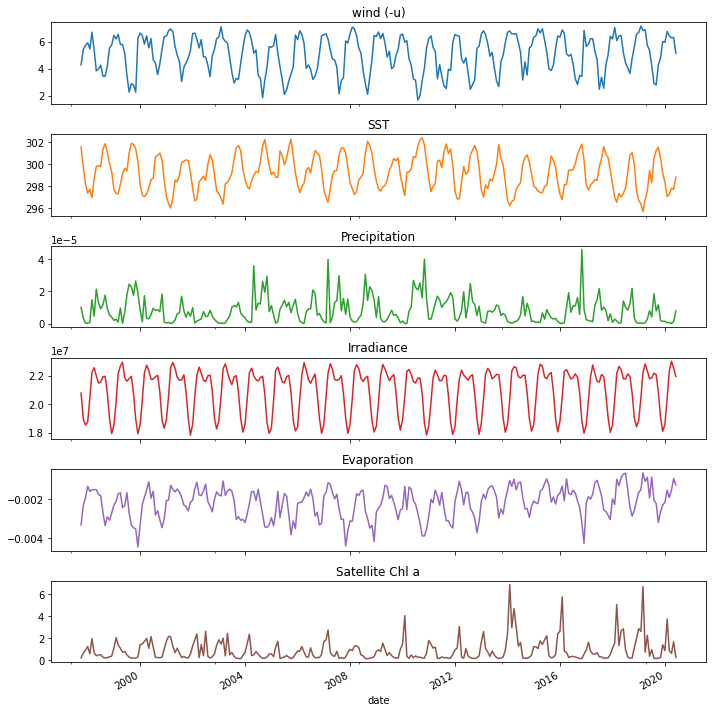

In [22]:
CSUB1.plot(subplots=True, figsize=(10,10), title=colnamelist, legend=False)
plt.tight_layout()
plt.savefig("PrelimAnalysis/Group1/1_overview.png")

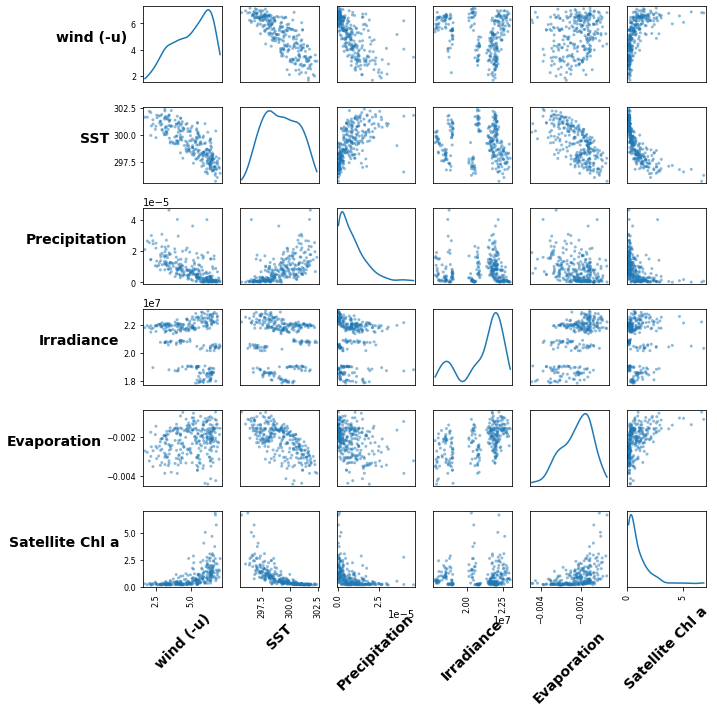

<Figure size 432x288 with 0 Axes>

In [16]:
colnamelist = ['wind (-u)', 'SST', 'Precipitation', 'Irradiance',
                   'Evaporation', 'Satellite Chl a']

plot_scatter_matrix(CSUB1, colnamelist)

plt.savefig("PrelimAnalysis/Group1/2_scatter.png")

[53.8064182  25.05364389]


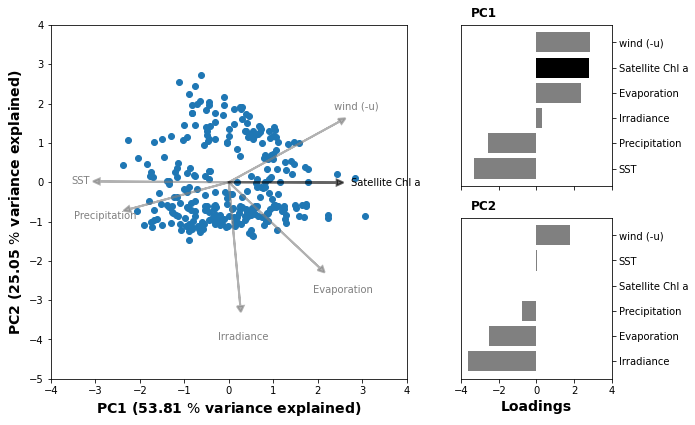

In [48]:
pca_analysis(CSUB1, colnamelist)

plt.savefig("PrelimAnalysis/Group1/3_PCA.png")

In [49]:
dataP = CSUB1

/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF Chlorophyll: oob-error=0.35, r^2=0.56, % variance explained=55.80
         VarName  Satellite_chla
0      wind (-u)        4.354860
1            SST       72.648970
2  Precipitation        2.979468
3     Irradiance        4.380994
4    Evaporation       15.635707
2     2.979468
0     4.354860
3     4.380994
4    15.635707
1    72.648970
Name: Satellite_chla, dtype: float64
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)


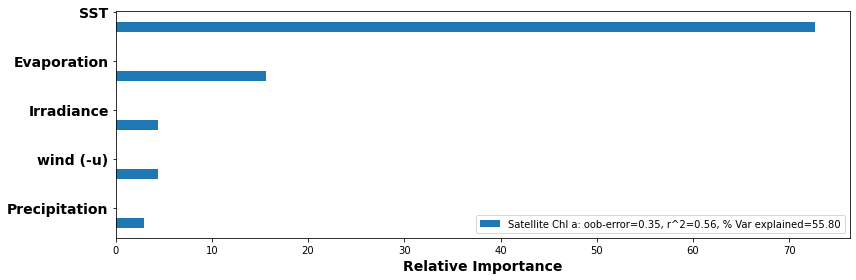

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

testsize = 0.25
vars2take = [0, 1, 2, 3, 4]
#Chlorophyll
X_trainBiom, X_testBiom, y_trainBiom, y_testBiom = train_test_split(dataP.take(vars2take, axis=1), 
                                                                    dataP.Satellite_chla,
                                                                    test_size=testsize)
RFregBiomass = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass.fit(X_trainBiom, y_trainBiom)
predicted_testBiom = RFregBiomass.predict(X_testBiom)




print('RF Chlorophyll: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
    explained_variance_score(y_testBiom, predicted_testBiom) * 100))



# change attributes below!
RFVarImp = pd.DataFrame(columns=['VarName', 'Satellite_chla'])
RFVarImp.VarName = colnamelist[:5]
RFVarImp.Satellite_chla = RFregBiomass.feature_importances_ * 100

print(RFVarImp)
print(RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla)
print(RFregBiomass)


fig2 = plt.figure()
varRFnum = 5
plt.barh(np.arange(varRFnum) - 0.3, RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla, height=.2,
         label='Satellite Chl a: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
             explained_variance_score(y_testBiom, predicted_testBiom) * 100))



plt.yticks(np.arange(varRFnum), RFVarImp.sort_values(by=['Satellite_chla']).VarName, fontsize=14, weight='bold')
plt.xlabel('Relative Importance', fontsize=14, weight='bold')
plt.legend()#fontsize='x-small')
fig2.set_figheight(4)
fig2.set_figwidth(12)
plt.tight_layout()
plt.show()
#fig2.savefig('PRESENTATION_TEST_RandomFOrest.png')

fig2.savefig("PrelimAnalysis/Group1/4_RF.png")

In [55]:
len(CSUB1)

274

In [66]:
#CSUB1[0:165]
#CSUB1[166:274]
CSUB1[200:270]

,u10,sst,mtpr,cdir,e,Satellite_chla
date,,,,,,
2014-05-01,6.599252,297.72134,1.381737e-06,22557664.0,-0.001550,3.056390
2014-06-01,5.945214,298.07562,2.433097e-06,21919120.0,-0.001197,1.279157
2014-07-01,5.210523,298.32660,5.385053e-06,21830768.0,-0.001150,1.619141
2014-08-01,3.159612,300.03174,1.675899e-05,22007264.0,-0.001924,0.218972
2014-09-01,4.504707,300.60403,4.793001e-06,22032672.0,-0.002510,0.179091
...,...,...,...,...,...,...
2019-10-01,4.259449,301.55566,1.166587e-05,20878864.0,-0.003203,0.191569
2019-11-01,4.804836,300.57890,1.944763e-06,19051168.0,-0.002662,0.253238
2019-12-01,6.010224,299.19257,1.407705e-06,18087056.0,-0.002316,1.409058


/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF Chlorophyll: oob-error=0.38, r^2=0.73, % variance explained=73.77
         VarName  Satellite_chla
0      wind (-u)       22.223782
1            SST       57.262497
2  Precipitation        3.858745
3     Irradiance        7.540107
4    Evaporation        9.114870
2     3.858745
3     7.540107
4     9.114870
0    22.223782
1    57.262497
Name: Satellite_chla, dtype: float64
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)


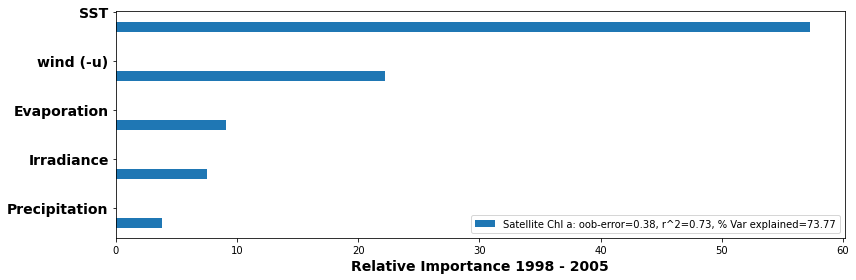

In [69]:
dataP = CSUB1[0:90] #  CSUB1[200:270] # 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

testsize = 0.25
vars2take = [0, 1, 2, 3, 4]
#Chlorophyll
X_trainBiom, X_testBiom, y_trainBiom, y_testBiom = train_test_split(dataP.take(vars2take, axis=1), 
                                                                    dataP.Satellite_chla,
                                                                    test_size=testsize)
RFregBiomass = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass.fit(X_trainBiom, y_trainBiom)
predicted_testBiom = RFregBiomass.predict(X_testBiom)




print('RF Chlorophyll: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
    explained_variance_score(y_testBiom, predicted_testBiom) * 100))



# change attributes below!
RFVarImp = pd.DataFrame(columns=['VarName', 'Satellite_chla'])
RFVarImp.VarName = colnamelist[:5]
RFVarImp.Satellite_chla = RFregBiomass.feature_importances_ * 100

print(RFVarImp)
print(RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla)
print(RFregBiomass)


fig2 = plt.figure()
varRFnum = 5
plt.barh(np.arange(varRFnum) - 0.3, RFVarImp.sort_values(by=['Satellite_chla']).Satellite_chla, height=.2,
         label='Satellite Chl a: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass.oob_score_, RFregBiomass.score(X_testBiom, y_testBiom),
             explained_variance_score(y_testBiom, predicted_testBiom) * 100))



plt.yticks(np.arange(varRFnum), RFVarImp.sort_values(by=['Satellite_chla']).VarName, fontsize=14, weight='bold')
plt.xlabel('Relative Importance 1998 - 2005', fontsize=14, weight='bold')
plt.legend()#fontsize='x-small')
fig2.set_figheight(4)
fig2.set_figwidth(12)
plt.tight_layout()
plt.show()

fig2.savefig("PrelimAnalysis/Group1/4_RF_earlyperiod.png")

# GROUP 3 PLots

In [70]:
CARIACO.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 316 entries, 1995-11-01 to 2021-11-01
Data columns (total 96 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    316 non-null    int64  
 1   cdww                          299 non-null    float64
 2   iews                          299 non-null    float64
 3   inss                          299 non-null    float64
 4   mcc                           299 non-null    float64
 5   mwp                           299 non-null    float64
 6   si10                          299 non-null    float64
 7   sp                            300 non-null    float64
 8   sst                           299 non-null    float64
 9   t2m                           299 non-null    float64
 10  tauoc                         299 non-null    float64
 11  u10                           299 non-null    float64
 12  ust                           300 non-null   

In [ ]:
- ERA5 cdir irradiance
- TimeSeries Temperature 35m
- TimeSeries 21° Isotherm
- TimeSeries NO3  35m
- TimeSeries PO4  35m
- TimeSeries SiO4  35m
​
- HPLC Func groups (8x)

In [164]:
CSUB2 = CARIACO[['cdir',
         'Isotherm_21',
         'NO3_USF_35m',
         'PO4_USF_35m',
         'SiO4_USF_35m',
                 'Diatom1',
                 'Cyano4',
                 'Chloro1',
                 'Dino1',
                 'Prasino3',
                 'Crypto1',
                 'Hapto6'
        ]].dropna()

CSUB2.columns

colnamelist = ['Irradiance', '21° C Isotherm', 'NO3 35m','PO4 35m','SiO4 35m',
                   'Diatom', 'Cyano', 'Chloro', 'Dino', 'Prasino', 'Crypto', 'Hapto']

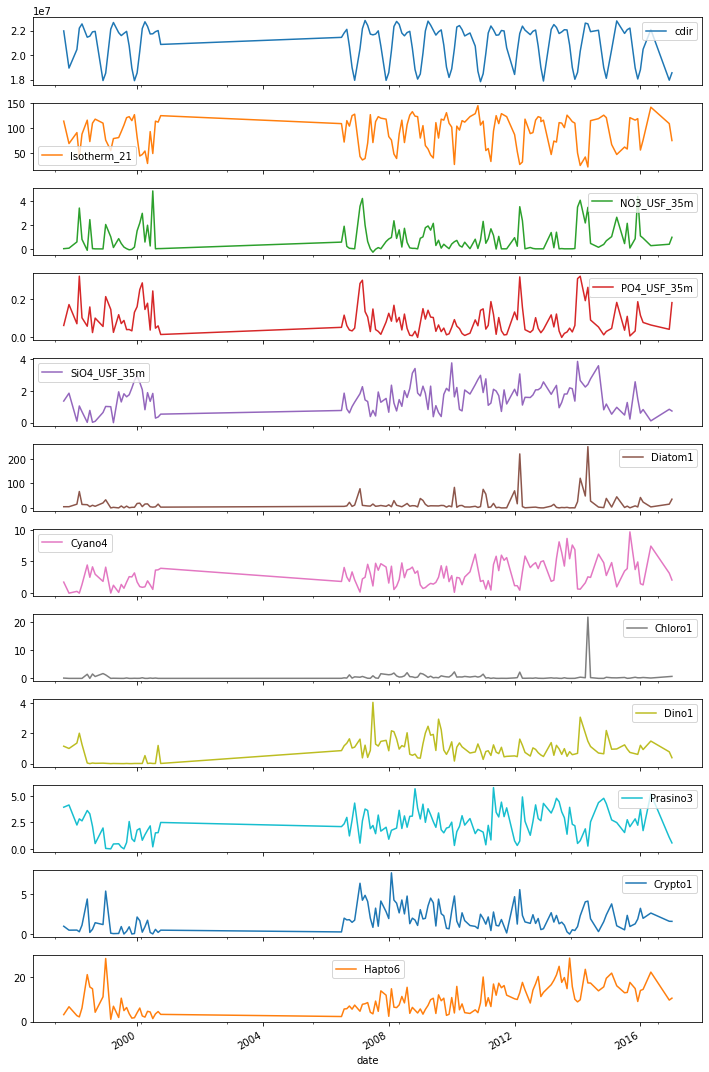

In [165]:
CSUB2.plot(subplots=True, figsize=(10,15))
plt.tight_layout()
plt.savefig("PrelimAnalysis/Group3/1_overview.png")

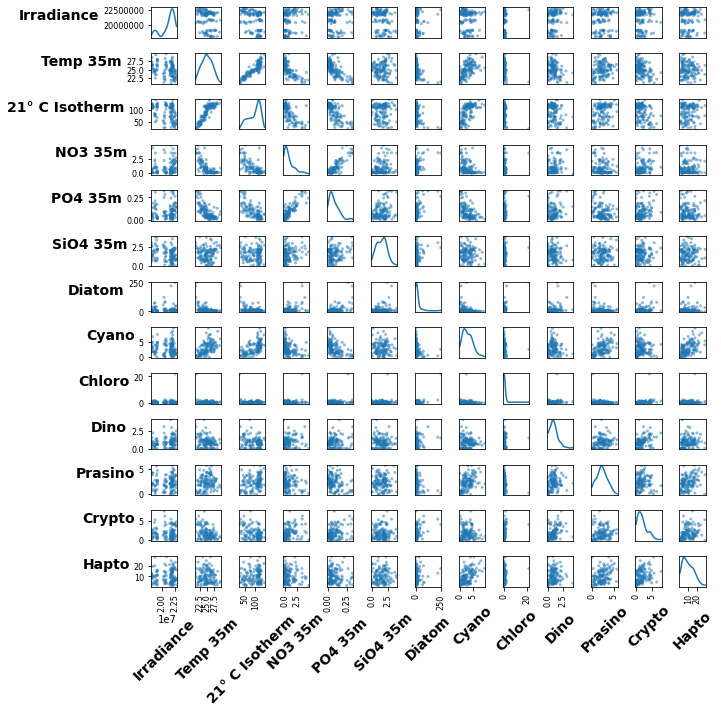

<Figure size 432x288 with 0 Axes>

In [87]:
plot_scatter_matrix(CSUB2, colnamelist)

plt.savefig("PrelimAnalysis/Group3/2_scatter.png")

[35.14308373 15.02686488]


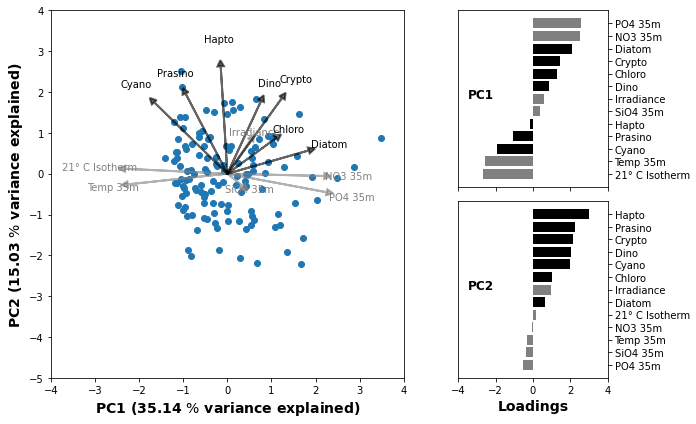

In [88]:

def pca_analysis2(dataP, colnamelist):
    """ PCA function """
    colnum = len(colnamelist)
    scaler = StandardScaler()
    scaler.fit(dataP)
    scaled_dataP = scaler.transform(dataP)

    pca_pytho = PCA(n_components=colnum, whiten=True)
    pcaresult = pca_pytho.fit_transform(scaled_dataP)
    expl_var = pca_pytho.explained_variance_ratio_[0:2] * 100
    print(expl_var)
    pcacoef = pd.DataFrame(columns=['PC1', 'PC2', 'VarName', 'VarColor'])
    pcacoef.PC1 = np.transpose(pca_pytho.components_)[:, 0]
    pcacoef.PC2 = np.transpose(pca_pytho.components_)[:, 1]
    pcacoef.VarName = colnamelist
    pcacoef.VarColor = ['grey', 'grey', 'grey', 'grey', 'grey',
                        'black', 'black', 'black', 'black', 'black', 'black', 'black']
    scalex = 1. / (pcaresult[:, 0].max() - pcaresult[:, 0].min())
    scaley = 1. / (pcaresult[:, 1].max() - pcaresult[:, 1].min())

    # need more values here
    offsetx = [1.15, 1.15, 1.25, 1.25, 1.25, 1.45, 1.25,  1.25, 1.25, 1.25, 1.25, 1.25, 1.25]
    offsety = [1.25, 1.25, 1.25, 1.25, 1.25, 1.30, 1.25,  1.25, 1.25, 1.25,1.25, 1.25,1.25]

    fig1 = plt.figure()
    gs = GridSpec(4, 4)
    ax1 = plt.subplot(gs[:, 1:3])
    ax2 = plt.subplot(gs[0:2, 3:4])
    ax3 = plt.subplot(gs[2:4, 3:4])

    ax1.scatter(pcaresult[:, 0], pcaresult[:, 1])
    for i in range(pcacoef.shape[0]):
        ax1.arrow(0, 0, pcacoef.PC1[i] / scalex, pcacoef.PC2[i] / scaley, color=pcacoef.VarColor[i], linewidth=2, alpha=0.6,
                  head_width=0.15, head_length=0.15)
        ax1.text(pcacoef.PC1[i] * offsetx[i] / scalex, pcacoef.PC2[i] * offsety[i] / scaley, pcacoef.VarName[i],
                 color=pcacoef.VarColor[i], ha='center', va='center')
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(-5, 4)
    ax1.set_xlabel(r'PC1 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[0]), fontsize=14, weight='bold')
    ax1.set_ylabel(r'PC2 ({expl:.2f} $\%$ variance explained)'.format(expl=expl_var[1]), fontsize=14, weight='bold')

    ax2.barh(range(colnum), pcacoef.sort_values(by=['PC1']).PC1 * 1.15 / scalex, color=pcacoef.sort_values(by=['PC1']).VarColor)
    ax2.set_xlim(-4, 4)
    ax2.set_xticklabels([])
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(colnum))
    ax2.set_yticklabels(pcacoef.sort_values(by=['PC1']).VarName)
    ax2.text(-3.5, 6, 'PC1', fontsize=12, weight='bold')

    ax3.barh(range(colnum), pcacoef.sort_values(by=['PC2']).PC2 * 1.15 / scaley, color=pcacoef.sort_values(by=['PC2']).VarColor)
    ax3.set_xlim(-4, 4)
    ax3.yaxis.tick_right()
    ax3.set_yticks(np.arange(colnum))
    ax3.set_yticklabels(pcacoef.sort_values(by=['PC2']).VarName)
    ax3.set_xlabel('Loadings', fontsize=14, weight='bold')
    ax3.text(-3.5, 6, 'PC2', fontsize=12, weight='bold')

    fig1.set_figheight(6)
    fig1.set_figwidth(12)
    plt.tight_layout()
    #plt.show()
    #fig1.savefig('Plots/PRESENTATION_PCA_tests.png')

pca_analysis2(CSUB2, colnamelist)

plt.savefig("PrelimAnalysis/Group3/3_PCA.png")

In [101]:
dataP = CSUB2

CSUB2['cdir'][20:31]

date
2000-01-01    18552192.0
2000-02-01    20335456.0
2000-03-01    22177856.0
2000-04-01    22724256.0
2000-05-01    22350768.0
2000-06-01    21731616.0
2000-07-01    21744816.0
2000-08-01    21919424.0
2000-09-01    22009360.0
2000-10-01    20877440.0
2006-07-01    21453936.0
Name: cdir, dtype: float64

In [112]:
testsize = 0.25
vars2take = [0, 1, 2, 3, 4, 5]

In [114]:
y_testBiom

date
2009-06-01     8.27
2012-12-01     0.08
2013-12-01     0.16
2007-07-01    15.74
2008-02-01     4.72
2015-02-01     3.38
1999-12-01     2.44
2011-03-01     2.09
2016-02-01    23.64
2006-10-01    22.78
1999-06-01     0.00
2007-10-01     9.82
2012-08-01     2.64
2008-12-01     4.14
2009-05-01     8.59
1999-10-01     0.68
1997-09-01     4.77
2016-12-01    15.27
2013-09-01     2.28
2012-02-01    16.75
2010-12-01     5.39
2011-05-01    18.35
1998-08-01    10.71
2007-09-01     7.85
2015-12-01     3.90
2006-09-01     8.30
2008-04-01    10.71
2000-02-01    19.36
2011-01-01    75.55
2011-07-01     2.45
2010-11-01     1.91
2000-04-01    15.67
2000-03-01     5.27
Name: Diatom1, dtype: float64

In [116]:
RFVarImp.sort_values(by=['Diatom1']).Diatom1

5     7.076996
3    10.001604
0    10.711552
2    12.153323
4    17.485674
1    42.570851
Name: Diatom1, dtype: float64

In [156]:
testsize = 0.2
vars2take = [0, 2, 3, 4, 5]
#Chlorophyll

DATA_tt_01 = train_test_split(dataP.take(vars2take, axis=1), dataP.Diatom1, test_size=testsize)
RFregBiomass_01 = RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=0)
RFregBiomass_01.fit(DATA_tt_01[0], DATA_tt_01[2])
predicted_testBiom_01 = RFregBiomass_01.predict(DATA_tt_01[1])

print('RF DIATOM: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass_01.oob_score_, RFregBiomass_01.score(DATA_tt_01[1], DATA_tt_01[3]),
    explained_variance_score(DATA_tt_01[3], predicted_testBiom_01) * 100))

/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF DIATOM: oob-error=0.76, r^2=0.67, % variance explained=67.16


In [153]:
DATA_tt_01

[                  cdir  Isotherm_21  NO3_USF_35m  PO4_USF_35m  SiO4_USF_35m
 date                                                                       
 2008-08-01  21846688.0        107.0     0.534016     0.047179      1.593760
 2008-10-01  20563248.0        133.0     0.040514     0.008978      3.135705
 2013-06-01  21767200.0        111.0     0.001940     0.033731      0.944600
 1999-12-01  17919824.0        127.0     0.144127     0.132091      2.665916
 2013-07-01  21896320.0        110.0     0.020386     0.000107      1.280941
 ...                ...          ...          ...          ...           ...
 2013-09-01  22059536.0        126.0     0.000000     0.028574      1.817738
 2010-12-01  17835120.0        106.0     0.733456     0.142236      2.997841
 2000-02-01  20335456.0         44.0     2.155607     0.251127      2.547448
 2009-06-01  22035600.0         40.0     2.128481     0.104721      0.377055
 2013-03-01  22109520.0         47.0     1.361214     0.118435      1.794388

/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF DIATOM: oob-error=0.33, r^2=0.26, % variance explained=38.72


/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF CYANO: oob-error=0.65, r^2=0.25, % variance explained=25.39


/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF HAPTO: oob-error=1.10, r^2=-0.08, % variance explained=-6.37


/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RF DINO: oob-error=1.04, r^2=-0.44, % variance explained=-43.41


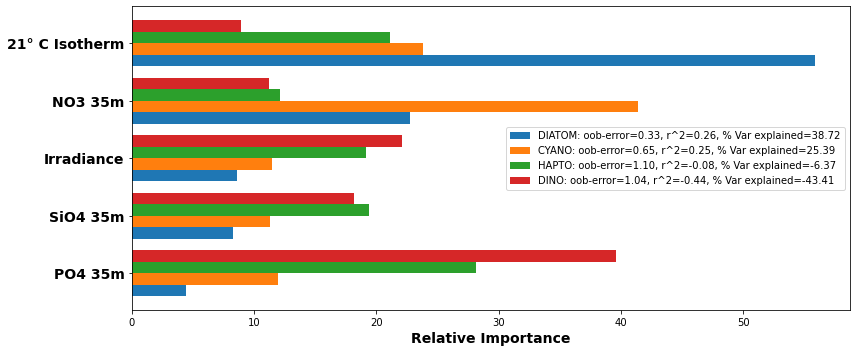

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

testsize = 0.25
vars2take = [0, 1, 2, 3, 4]
#Chlorophyll

DATA_tt_01 = train_test_split(dataP.take(vars2take, axis=1), dataP.Diatom1, test_size=testsize)
RFregBiomass_01 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass_01.fit(DATA_tt_01[0], DATA_tt_01[2])
predicted_testBiom_01 = RFregBiomass_01.predict(DATA_tt_01[1])

print('RF DIATOM: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass_01.oob_score_, RFregBiomass_01.score(DATA_tt_01[1], DATA_tt_01[3]),
    explained_variance_score(DATA_tt_01[3], predicted_testBiom_01) * 100))



X_trainBiom1, X_testBiom1, y_trainBiom1, y_testBiom1 = train_test_split(dataP.take(vars2take, axis=1), 
                                                                    dataP.Cyano4,
                                                                    test_size=testsize)
RFregBiomass1 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass1.fit(X_trainBiom1, y_trainBiom1)
predicted_testBiom1 = RFregBiomass1.predict(X_testBiom1)

print('RF CYANO: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass1.oob_score_, RFregBiomass1.score(X_testBiom1, y_testBiom1),
    explained_variance_score(y_testBiom1, predicted_testBiom1) * 100))


DATA_tt_02 = train_test_split(dataP.take(vars2take, axis=1), dataP.Hapto6, test_size=testsize)
RFregBiomass_02 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass_02.fit(DATA_tt_02[0], DATA_tt_02[2])
predicted_testBiom_02 = RFregBiomass_02.predict(DATA_tt_02[1])

print('RF HAPTO: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass_02.oob_score_, RFregBiomass_02.score(DATA_tt_02[1], DATA_tt_02[3]),
    explained_variance_score(DATA_tt_02[3], predicted_testBiom_02) * 100))

#########

DATA_tt_03 = train_test_split(dataP.take(vars2take, axis=1), dataP.Dino1, test_size=testsize)
RFregBiomass_03 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
RFregBiomass_03.fit(DATA_tt_03[0], DATA_tt_03[2])
predicted_testBiom_03 = RFregBiomass_03.predict(DATA_tt_03[1])

print('RF DINO: oob-error=%.2f, r^2=%.2f, %% variance explained=%.2f' % (
    1. - RFregBiomass_03.oob_score_, RFregBiomass_03.score(DATA_tt_03[1], DATA_tt_03[3]),
    explained_variance_score(DATA_tt_03[3], predicted_testBiom_03) * 100))
##############

# change attributes below!
RFVarImp = pd.DataFrame(columns=['VarName', 'Diatom1', 'Cyano4', 'Hapto6', 'Dino1'])
RFVarImp.VarName = colnamelist[:5]
RFVarImp.Diatom1 = RFregBiomass_01.feature_importances_ * 100
RFVarImp.Cyano4 = RFregBiomass1.feature_importances_ * 100

RFVarImp.Hapto6 = RFregBiomass_02.feature_importances_ * 100
RFVarImp.Dino1 = RFregBiomass_03.feature_importances_ * 100


fig2 = plt.figure()
varRFnum = 5
plt.barh(np.arange(varRFnum) - 0.3, RFVarImp.sort_values(by=['Diatom1']).Diatom1, height=.2,
         label='DIATOM: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass_01.oob_score_, RFregBiomass_01.score(DATA_tt_01[1], DATA_tt_01[3]),
             explained_variance_score( DATA_tt_01[3], predicted_testBiom_01) * 100))

plt.barh(np.arange(varRFnum) -0.1 , RFVarImp.sort_values(by=['Diatom1']).Cyano4, height=.2,
         label='CYANO: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass1.oob_score_, RFregBiomass1.score(X_testBiom1, y_testBiom1),
             explained_variance_score(y_testBiom1, predicted_testBiom1) * 100))

plt.barh(np.arange(varRFnum) +0.1, RFVarImp.sort_values(by=['Diatom1']).Hapto6, height=.2,
         label='HAPTO: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass_02.oob_score_, RFregBiomass_02.score(DATA_tt_02[1], DATA_tt_02[3]),
             explained_variance_score( DATA_tt_02[3], predicted_testBiom_02) * 100))

plt.barh(np.arange(varRFnum) +0.3, RFVarImp.sort_values(by=['Diatom1']).Dino1, height=.2,
         label='DINO: oob-error=%.2f, r^2=%.2f, %% Var explained=%.2f' % (
             1. - RFregBiomass_03.oob_score_, RFregBiomass_03.score(DATA_tt_03[1], DATA_tt_03[3]),
             explained_variance_score( DATA_tt_03[3], predicted_testBiom_03) * 100))


plt.yticks(np.arange(varRFnum), RFVarImp.sort_values(by=['Diatom1']).VarName, fontsize=14, weight='bold')
plt.xlabel('Relative Importance', fontsize=14, weight='bold')
plt.legend()#fontsize='x-small')
fig2.set_figheight(5)
fig2.set_figwidth(12)
plt.tight_layout()
plt.show()
#fig2.savefig('PRESENTATION_TEST_RandomFOrest.png')

fig2.savefig("PrelimAnalysis/Group3/4_RF_3.png")

In [ ]:
/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
RF DIATOM: oob-error=0.40, r^2=0.15, % variance explained=22.04
/Users/bpo/opt/anaconda3/envs/xsimlab2/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
RF CYANO: oob-error=0.70, r^2=0.04, % variance explained=14.95
          VarName    Diatom1     Cyano4
0      Irradiance   6.069519  10.928615
1        Temp 35m  56.331200  25.887256
2  21° C Isotherm  23.857137  20.860136
3         NO3 35m   3.820999  17.083517
4         PO4 35m   7.252599  17.938339
5        SiO4 35m   2.668547   7.302137
5     2.668547
3     3.820999
0     6.069519
4     7.252599
2    23.857137
1    56.331200
Name: Diatom1, dtype: float64
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)